# SAC (Soft Actor-Critic)

SAC (Soft Actor-Critic) is one of today's popular algorithm, which is based on **off-policy** DDPG discussed in [here](./05-ddpg.ipynb).<br>
However, unlike DDPG, SAC applies entropy regularization and trains a stochastic policy, not a deterministic policy.

Entropy is defined as $ H(P) = -\int P(x) \log P(x) = E_x[-\log P(x)] $ and it means how $ P(\cdot) $ is distributed intuitively.<br>
For instance, if it has 8 possible states, each of which is equally likely in discrete distribution, it will have $ H(P) = -\sum P(x) \log P(x) = -8 \times \frac{1}{8} \log_2 \frac{1}{8} = 3 $. (This implies that it needs 3 bits evenly.) If the distribution is $ (\frac{1}{2}, \frac{1}{4}, \frac{1}{8}, \frac{1}{16}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}, \frac{1}{64}) $, it will have $ H(P) = -\frac{1}{2} \log_2 \frac{1}{2} - \frac{1}{4} \log_2 \frac{1}{4} - \frac{1}{8} \log_2 \frac{1}{8} - \frac{1}{16} \log_2 \frac{1}{16} - 4 \times \frac{1}{64} \log_2 \frac{1}{64} = 2 $.<br>
(Note that, for simplicity, I have replaced the base e of logarithm with 2.)<br>

As you can see above, entropy will be larger, when the distribution has much randomness.

> Note : In continuous distribution, it's known that the distribution that maximizes the entropy is Gaussian distribution. Here I don't go into details, but KL-divergence (the penalty for large updates) discussed in [PPO](./04-ppo.ipynb) is closely related with this entropy term.

In SAC, instead of using a reward expectation $ r_t + \gamma (d_t - 1) Q_{{\phi}^{\prime}} $ used in DDPG, it applies $ r_t + \gamma (d_t - 1) (Q_{{\phi}^{\prime}} + \alpha H(P)) $ (where $\alpha$ is a coefficient parameter for entropy weight, called entropy temperature) in order to balance between exploitation and exploration.<br>
Even if the estimated Q-value increases, it might be rejected when the entropy is largely reduced.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

In [2]:
# !pip install torch numpy gymnasium matplotlib

In [3]:
import random
# import gymnasium as gym
import gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)

env_name = "CartPole-v1"

if env_name == "CartPole-v1":
    max_steps = 500
    convergence_criteria = 495.0
elif env_name == "CartPole-v0":
    max_steps = 200
    convergence_criteria = 195.0

In order to prevent from overflows, I apply double precision for float operations.

In [5]:
torch.set_default_dtype(torch.float64)

Unlike [DDPG](./05-ddpg.ipynb), we can use discrete action space in SAC. (See below for this reason.)<br>
We then now use standard CartPole agent in Gymnasium.

In [7]:
env = gym.make(env_name)

Unlike DDPG, SAC trains a stochastic policy $ \pi_{\theta}(\cdot) $ (where $ \theta $ is parameters) instead of a deterministic policy $ \mu_{\theta}(\cdot) $. (And we don't use target policy network $ \pi_{\theta^{\prime}} $.)<br>
In this example, I use categorical distribution (same as, used in [policy gradient](./02-policy-gradient.ipynb) and [PPO](./04-ppo.ipynb) example) for a policy $ P(\cdot | \pi_\theta(s)) $, because it's discrete action space:

> Note : For the bounded continuous action space between $ l $ and $ h $, use Gaussian distribution as follows.<br>
> $ P(\cdot | \pi_\theta(s)) = ((tanh(\mathcal{N}(\mu_{\theta}(s), \sigma_{\theta}(s))) + 1.0) / 2.0) \times (h - l) + l  $

Because we use a stochastic policy, we don't then need Ornstein-Uhlenbeck noise used in [DDPG](./05-ddpg.ipynb) any more.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Policy net (pi_theta)
class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

pi_model = PolicyNet().to(device)

# Pick up action (for each step in episode)
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float64).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = pi_model(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        #   --> size : (1)
        a = torch.multinomial(probs, num_samples=1)
        #   --> size : ()
        a = a.squeeze(dim=0)
        # Return
        return a.tolist()

Same as clipped double-Q (twin-Q) DDPG method (see the latter part in [here](./05-ddpg.ipynb)), we use 2 Q-networks - $ Q_{\phi_1}(s), Q_{\phi_2}(s) $ - and corresponding 2 target networks - $ Q_{\phi_1^{\prime}}(s), Q_{\phi_2^{\prime}}(s) $.

You will find that this is different from the one used in [DDPG](./05-ddpg.ipynb). (In DDPG, we have used $Q(s, a)$.)<br>
For categorical distribution with the depth n (in this example, n=2), the output of $ Q(\cdot) $ is n-dimensional tensor, in which each element represents the expectation of Q-value for the corresponding action. And we then use $ Q(s) \cdot \tilde{a} $ (i.e, dot product operation) instead of $ Q(s, a) $, where $ \tilde{a} $ is one hot tensor for action $ a $.<br>
Because of this reason, we use $Q(s)$ instead of $Q(s, a)$.

In [11]:
class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        outs = self.output(outs)
        return outs

hidden_layers = 64
q_origin_model1 = QNet(hidden_layers).to(device)  # Q_phi1
q_origin_model2 = QNet(hidden_layers).to(device)  # Q_phi2
q_target_model1 = QNet(hidden_layers).to(device)  # Q_phi1'
q_target_model2 = QNet(hidden_layers).to(device)  # Q_phi2'
_ = q_target_model1.requires_grad_(False)  # target model doen't need grad
_ = q_target_model2.requires_grad_(False)  # target model doen't need grad

As we saw in [clipped double-Q DDPG](./05-ddpg.ipynb), we optimize policy parameter $ \theta $ to maximize $ Q_{\phi_1}(s, a^*) + \alpha H(P(\cdot | \pi_\theta(s))) $ where $ a^* $ is an optimal action.

As I have mentioned above, $ H(P) = E_x[-\log P(x)] $.<br>
In this categorical distribution (in discrete action space), $ H $ will then be the following dot product :

$ H(P) = H(P(\cdot | \pi_\theta(s))) = -\pi_\theta(s) \cdot \log \pi_\theta(s) $

where $ \pi_\theta(s) $ is one hot probability.

For $ Q(s, a^*) $ term, it will become the following dot product. (See above for this reason.) :

$ Q_{\phi_1}(s, a^*) = Q_{\phi_1}(s) \cdot \pi_\theta(s) $

To summarize, we should optimize $ \theta $ to maximize :

$ E\left[ \pi_\theta(s) \cdot Q_{\phi_1}(s) - \alpha \pi_\theta(s) \cdot \log \pi_\theta(s) \right] = E\left[ \pi_\theta(s) \cdot (Q_{\phi_1}(s) - \alpha \log \pi_\theta(s)) \right] $

> Note : Here I have used a constant $ \alpha $, but the appropriate temperature ($ \alpha $) depends on the magnitude of rewards, and it's not so easy to determine appropriate temprature, because it also depends on policy, which improves over time during training.<br>
> There exists a variation of SAC, in which $ \alpha $ is also learned over the course of training to align to appropriate entropy.

In [13]:
alpha = 0.05
learning_rate = 0.005
opt_pi = torch.optim.AdamW(pi_model.parameters(), lr=learning_rate)

class categorical:
    def __init__(self, s):
        logits = pi_model(s)
        self._prob = F.softmax(logits, dim=-1)
        self._logp = torch.log(self._prob)

    # probability (sum is 1.0) : P
    def prob(self):
        return self._prob

    # log probability : log P()
    def logp(self):
        return self._logp

def optimize_theta(states):
    # Convert to tensor
    states = torch.tensor(states, dtype=torch.float64).to(device)
    # Disable grad in q_origin_model1 before computation
    # (or use q_value.detach() not to include in graph)
    for p in q_origin_model1.parameters():
        p.requires_grad = False
    # Optimize
    opt_pi.zero_grad()
    dist = categorical(states)
    q_value = q_origin_model1(states)
    term1 = dist.prob()
    term2 = q_value - alpha * dist.logp()
    expectation = term1.unsqueeze(dim=1) @ term2.unsqueeze(dim=2)
    expectation = expectation.squeeze(dim=1)
    (-expectation).sum().backward()
    opt_pi.step()
    # Enable grad again
    for p in q_origin_model1.parameters():
        p.requires_grad = True

Same as we saw in [clipped double-Q DDPG](./05-ddpg.ipynb), we optimize parameter $ \phi_1, \phi_2 $ as follows :

- Optimize $ \phi_1 $ to minimize $ E\left[ \left( Q_{\phi_1}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $
- Optimize $ \phi_2 $ to minimize $ E\left[ \left( Q_{\phi_2}(s_t, a_t) - \left( r_t + \gamma (1 - d_t) \left( \min_{i=1,2} Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) + \alpha H(P(\cdot | \pi_\theta(s_{t+1}))) \right) \right) \right)^2 \right] $

in which :

- $ Q_{\phi_i}(s_t, a_t) = Q_{\phi_i}(s_t) \cdot \tilde{a_t} $ where $ \tilde{a_t} $ is one hot vector of $ a_t $
- $ Q_{{\phi_i}^{\prime}}(s_{t+1},a^*_{t+1}) =  Q_{\phi_i^{\prime}}(s_{t+1}) \cdot \pi_\theta(s_{t+1}) $ where $ \pi_\theta(s_{t+1}) $ is one hot probability
- $ H(P(\cdot | \pi_\theta(s_{t+1}))) = -\pi_\theta(s_{t+1}) \cdot \log \pi_\theta(s_{t+1}) $

In [15]:
gamma = 0.97

opt_q1 = torch.optim.AdamW(q_origin_model1.parameters(), lr=learning_rate)
opt_q2 = torch.optim.AdamW(q_origin_model2.parameters(), lr=learning_rate)

def optimize_phi(states, actions, rewards, next_states, dones):
    #
    # Convert to tensor
    #
    states = torch.tensor(states, dtype=torch.float64).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float64).to(device)
    rewards = rewards.unsqueeze(dim=1)
    next_states = torch.tensor(next_states, dtype=torch.float64).to(device)
    dones = torch.tensor(dones, dtype=torch.float64).to(device)
    dones = dones.unsqueeze(dim=1)

    #
    # Compute r + gamma * (1 - d) (min Q(s_next,a_next') + alpha * H(P))
    #
    with torch.no_grad():
        # min Q(s_next,a_next')
        q1_tgt_next = q_target_model1(next_states)
        q2_tgt_next = q_target_model2(next_states)
        dist_next = categorical(next_states)
        q1_target = q1_tgt_next.unsqueeze(dim=1) @ dist_next.prob().unsqueeze(dim=2)
        q1_target = q1_target.squeeze(dim=1)
        q2_target = q2_tgt_next.unsqueeze(dim=1) @ dist_next.prob().unsqueeze(dim=2)
        q2_target = q2_target.squeeze(dim=1)
        q_target_min = torch.minimum(q1_target, q2_target)
        # alpha * H(P)
        h = dist_next.prob().unsqueeze(dim=1) @ dist_next.logp().unsqueeze(dim=2)
        h = h.squeeze(dim=1)
        h = -alpha * h
        # total
        term2 = rewards + gamma * (1.0 - dones) * (q_target_min + h)

    #
    # Optimize critic loss for Q-network1
    #
    opt_q1.zero_grad()
    one_hot_actions = F.one_hot(actions, num_classes=2).double()
    q_value1 = q_origin_model1(states)
    term1 = q_value1.unsqueeze(dim=1) @ one_hot_actions.unsqueeze(dim=2)
    term1 = term1.squeeze(dim=1)
    loss_q1 = F.mse_loss(
        term1,
        term2,
        reduction="none")
    loss_q1.sum().backward()
    opt_q1.step()

    #
    # Optimize critic loss for Q-network2
    #
    opt_q2.zero_grad()
    one_hot_actions = F.one_hot(actions, num_classes=2).double()
    q_value2 = q_origin_model2(states)
    term1 = q_value2.unsqueeze(dim=1) @ one_hot_actions.unsqueeze(dim=2)
    term1 = term1.squeeze(dim=1)
    loss_q2 = F.mse_loss(
        term1,
        term2,
        reduction="none")
    loss_q2.sum().backward()
    opt_q2.step()

As we saw in [clipped double-Q DDPG](./05-ddpg.ipynb), target parameters $\phi_1^{\prime}, \phi_2^{\prime}$ are delayed with coefficient parameter (hyper-parameter) $ \tau $.

In [17]:
tau = 0.003

def update_target():
    for var, var_target in zip(q_origin_model1.parameters(), q_target_model1.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data
    for var, var_target in zip(q_origin_model2.parameters(), q_target_model2.parameters()):
        var_target.data = tau * var.data + (1.0 - tau) * var_target.data

As we saw in [DDPG](./05-ddpg.ipynb), we use replay buffer to prevent from learning only for recent experiences.

In [19]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, batch_size):
        items = random.sample(self.buffer, batch_size)
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(20000)

Now let's put it all together !

In [21]:
batch_size = 25
epoch =1000


# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position


reward_records = []
for i in range(epoch):
    # Run episode till done
    env.seed(i)
    s = env.reset()
    env.seed(i)
    
    done = False
    cum_reward = 0
    while not done:
        a = pick_sample(s)
        s_next, r, term, trunc = env.step(a)
        
        
        # Compute custom rewards
        # Extract state variables
        x = abs(s_next[0])  # Cart position (absolute value)
        theta = abs(s_next[2])  # Pole angle (absolute value)
        
        weight1=0.165
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward
        
        done = term or trunc
        # buffer.add([s.tolist(), a, r, s_next.tolist(), float(term)])
        
        buffer.add([s.tolist(), a, reward, s_next.tolist(), float(term)])
        cum_reward += r
        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            optimize_theta(states)
            optimize_phi(states, actions, rewards, n_states, dones)
            update_target()
        s = s_next

    # Output total rewards in episode (max 500)
    print("Run episode{} with rewards {}".format(i, cum_reward), end="\r")
    reward_records.append(cum_reward)

    # stop if reward mean > 475.0
    if np.average(reward_records[-10:]) >= convergence_criteria:
        break

env.close()
print("\nDone")

Run episode122 with rewards 500.0
Done


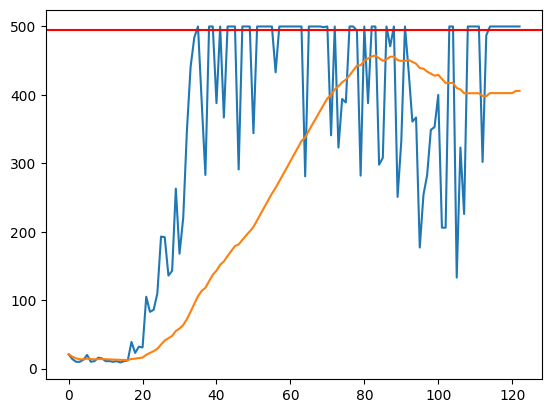

In [22]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(reward_records)
plt.plot(average_reward)

plt.axhline(y=convergence_criteria, color='r', linestyle='-')
plt.show()

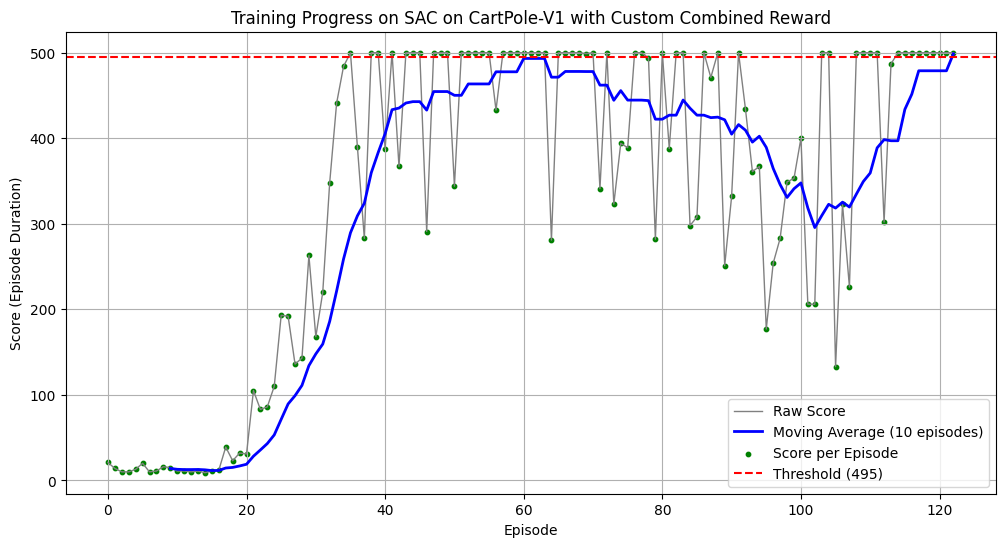

In [23]:
# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):
    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=495, color='red', linestyle='--', label='Threshold (495)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    # plt.title('Training Progress of %s on CartPole with Custom Combined Reward'%(name))
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_train('SAC on CartPole-V1', reward_records, 10)

In [24]:
import pandas as pd
import seaborn as sns

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
count    100.0
mean     500.0
std        0.0
min      500.0
25%      500.0
50%      500.0
75%      500.0
max      500.0
Name: score, dtype: float64
success
True    100
Name: count, dtype: int64


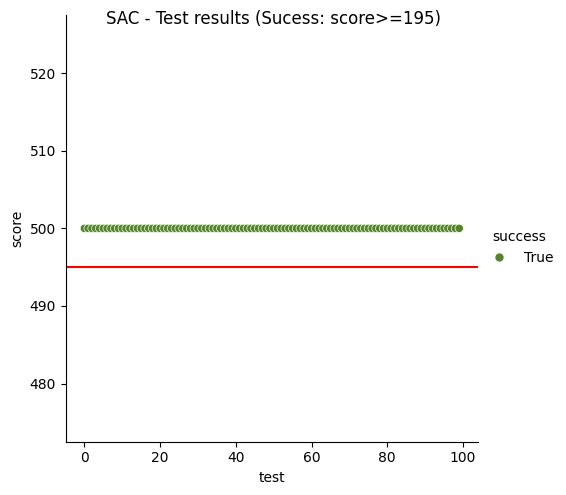

In [25]:

def test_agent_500(i, print_reward=False):
    env = gym.make('CartPole-v1')
    env.seed(i)
    s = env.reset()
    env.seed(i)
    rewards = []
    obs=[]
    for t in range(500):
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        done = term or trunc
        rewards.append(r)
        #print(sum(rewards))  
        if done:
            rew = sum(rewards)
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


def plot_test_results_500(method='', total=100):
    test_scores = []
    for i in range(total):
        test_scores.append(test_agent_500(i, print_reward=False))
        
    print(test_scores)

    colors = {True: "#54852A", False: "#E33079"}
    
    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=495)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    ax = sns.relplot(data=test_df, x="test", y="score", hue="success", palette=colors)
    # ax.set_title('Test results sucess')
    # ax.set_ylabel('Reward')
    
    ax.fig.suptitle(method + " - Test results (Sucess: score>=195)")
    plt.axhline(y=495, color='r', linestyle='-')
    
    plt.show()
    
plot_test_results_500('SAC', total=100)

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
test_score: 200.0
test_success_percentage: 100
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: score, dtype: float64
success
True    100
Name: count, dtype: int64


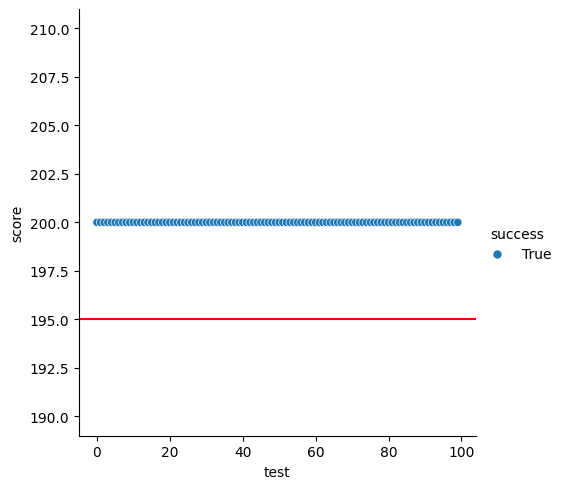

In [26]:


def test_agent(i, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(i)
    s = env.reset()
    env.seed(i)
    rewards = []
    obs=[]
    for t in range(200):
        a = pick_sample(s)
        s, r, term, trunc = env.step(a)
        done = term or trunc
        rewards.append(r)
        #print(sum(rewards))  
        if done:
            rew = sum(rewards)
            if print_reward:
                print("Reward:", rew)
            return rew
    env.close()


def plot_test_results(total=100):
    random.seed(20)
    np.random.seed(20)
    torch.manual_seed(20)

    test_scores = []
    for i in range(total):
        test_scores.append(test_agent(i, print_reward=False))
        
    print(test_scores)

    print('test_score:', np.mean(test_scores))
    print('test_success_percentage:', len([i for i in test_scores if i>=195]))
    
    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=195)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success")
    plt.axhline(y=195, color='r', linestyle='-')
    plt.show()
    
plot_test_results(total=100)

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0

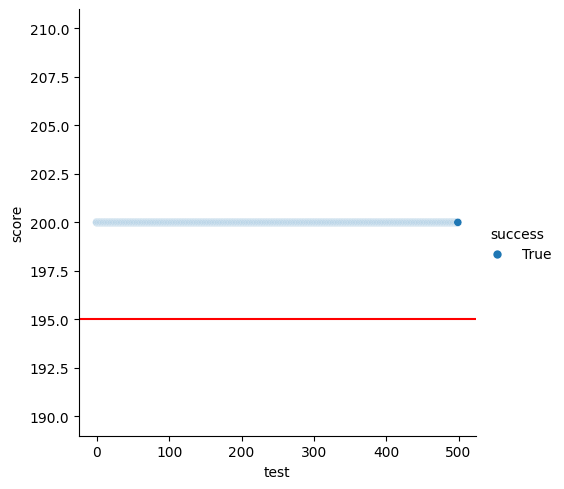

In [27]:
plot_test_results(total=500)